In [98]:
import numpy as np
from scipy import stats
import pickle
import pandas as pd
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)
from dipy.align.imaffine import (transform_centers_of_mass,
                                 AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)

In [99]:
def read_kImage(path):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(path)
    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    return ct_scan

In [100]:
def extract_voxel_data(series_path):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames( series_path )
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    image_3d = sitk.GetArrayFromImage(image)
    return image_3d

In [4]:
def extract_slice_data(img_3d, ijk):
    state = False
    k_string = ijk.split()[2]
    max_bandwith = img_3d.shape[0]
    possible_k = int (k_string)
    if (possible_k >= max_bandwith):
        possible_k = max_bandwith -1
        slice_index = possible_k
        state = True
        print("The ijk requested is {}, there was an error since the shapes of the image is {}".format(ijk,str(img_3d.shape)))
    else:
        slice_index = possible_k
        print("The ijk requested is {},OK since shapes of the image is {}".format(ijk,str(img_3d.shape)))
    return state, img_3d[slice_index,:,:]

In [5]:
def subvoxel (img_3d,ijk, window):
    new_img3d = np.empty(shape = (3,img_3d.shape[1], img_3d.shape[2]))
    ijk = ijk.split()
    max_bandwith = img_3d.shape[0] - 1
    if (int(ijk[2]) == max_bandwith):
        new_img3d[0,:,:] = img_3d[int(ijk[2])-1,:,:] #n-1
        new_img3d[1,:,:] = img_3d[int(ijk[2]),:,:] #n
        new_img3d[2,:,:] = img_3d[int(ijk[2]),:,:] #n
    else:
        if (int(ijk[2]) == 0):
            new_img3d[0,:,:] = img_3d[int(ijk[2]),:,:] #0
            new_img3d[1,:,:] = img_3d[int(ijk[2]),:,:] #0
            new_img3d[2,:,:] = img_3d[int(ijk[2])+1,:,:] #1
        else:
            new_img3d[0,:,:] = img_3d[int(ijk[2])-1,:,:] #n-1
            new_img3d[1,:,:] = img_3d[int(ijk[2]),:,:] #n
            new_img3d[2,:,:] = img_3d[int(ijk[2])+1,:,:] #n+1
    window = window//2
    new_img3d = new_img3d[:, int(ijk[0])-window : int(ijk[0])+window, int(ijk[1])-window : int(ijk[1])+window]
    return new_img3d

In [6]:
def generate_training_tables():
    basedir = "../1/train/ProstateX-TrainingLesionInformationv2/ProstateX-TrainingLesionInformationv2"
    findingsfile = "{}/{}".format(basedir,"ProstateX-Findings-Train.csv")
    imagesfile = "{}/{}".format(basedir,"ProstateX-Images-Train.csv")
    kimagesfile = "{}/{}".format(basedir,"ProstateX-Images-KTrans-Train.csv")
    #Generamos las 3 tablas básicas a partir de los archivos.cvs
    findings_table = pd.read_csv(findingsfile)
    images_table = pd.read_csv(imagesfile)
    kimages_table = pd.read_csv(kimagesfile)
    #Operación de inner join entre tablas.
    join_kimages_table = pd.merge(left=findings_table, right= kimages_table, how ="inner", on=["ProxID","fid","pos"])
    join_images_table =  pd.merge(left=findings_table, right=  images_table, how ="inner", on=["ProxID","fid","pos"])
    #agregamos una columna para insertar la imagen
    join_images_table["MRI"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["MRI3D"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["MRI3DRegistered"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["ijkRegistered"] = pd.Series(False, index= join_images_table.index)
    join_images_table["MRIPatch3DRegistered"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_images_table["MRIPatch3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_images_table["State"] = pd.Series(False, index= join_images_table.index)
    join_kimages_table["Kimg"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["Kimg3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["Kimg3DRegistered"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["KimgPatch3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["State"] = pd.Series(False, index= join_kimages_table.index)
    return join_images_table, join_kimages_table

In [7]:
def set_MRI_value(index,image2d,image3d,state):
    window = 40
    row = join_images_table.iloc[index]
    join_images_table.at[index,"MRI"] = image2d
    join_images_table.at[index,"MRI3D"] = image3d
    join_images_table.at[index,"State"] = state
    if state == False:
        join_images_table.at[index,"MRIPatch3D"] = subvoxel(img_3d=image3d, ijk=row.ijk, window=window)
    else:
        join_images_table.at[index,"MRIPatch3D"] = np.empty(shape= image3d.shape)
    

In [8]:
def set_kImg_value(index,image2d,image3d,state):
    window = 40
    row = join_kimages_table.iloc[index]
    join_kimages_table.at[index,"Kimg"] = image2d
    join_kimages_table.at[index,"Kimg3D"] = image3d
    join_kimages_table.at[index,"State"] = state
    if state == False:
        join_kimages_table.at[index,"KimgPatch3D"] = subvoxel(img_3d=image3d, ijk=row.ijk, window=window)
    else:
        join_kimages_table.at[index,"KimgPatch3D"] = np.empty(shape= image3d.shape)
    

In [9]:
def insert_MRI_images():
    for row in range (len(join_images_table)):
        patient_id = join_images_table.ProxID.iloc[row]
        series_name = join_images_table.DCMSerDescr.iloc[row]
        series_id = join_images_table.DCMSerNum.iloc[row]
        slice_ijk = join_images_table.ijk.iloc[row]
        path = "../1/Train/PROSTATEx/{}/".format(patient_id)#Selects the Patient ID
        path = "{}/{}".format(path,os.listdir(path)[0])#Selects the default folder inside the patient
        sequences = os.listdir(path) # Selects all the sequences
        sequence = [ sequence for sequence in sequences if sequence[0:len(str(series_id))] == str(series_id) ] [0]
        # Selects the only sequence that matches the condition.
        path = "{}/{}".format(path,sequence)
        image_3d = extract_voxel_data(path)
        state, image_2d = extract_slice_data(image_3d,slice_ijk)
        set_MRI_value(row, image_2d,image_3d,state)
        print("Se ha cargado la imagen MRI2D y MRI3D #{} para el paciente {} serie: {} ".format(row,patient_id,series_name))
    del path, patient_id, series_name, series_id,sequence,sequences, image_3d, image_2d

In [10]:
def checkout_MRI_table_problems():
    MRI_problems_table = join_images_table[join_images_table["State"] == True] 
    print("There were {} problems".format(len(MRI_problems_table)))
    percent = 100*float(len(MRI_problems_table)/len(join_images_table))
    print("It was the  {0:.5f}% of the dataset".format(percent))
    display(MRI_problems_table[["ProxID","fid","ClinSig","State","Name","DCMSerDescr"]])
    
    patient_problems = MRI_problems_table.ProxID.unique()
    print("The following patients have almost 1 currupted image. {}".format(patient_problems))
    candidate_table = join_images_table
    for patient in patient_problems:
        candidate_table = candidate_table[candidate_table["ProxID"] != patient]
    print("This would be the table with none of the patients with atleast 1 problem.")
    display(candidate_table[["ProxID","fid","ClinSig","State","Name","DCMSerDescr"]])
    del MRI_problems_table, percent,  patient_problems, candidate_table, patient


In [11]:
def checkout_Kimgs_problems():
    k_problems_table = join_kimages_table[join_kimages_table["State"] == True] 
    print("There were {} problems".format(len(k_problems_table)))
    percent = 100*float(len(k_problems_table)/len(join_kimages_table))

    print("It was the  {0:.5f}% of the dataset".format(percent))
    display(k_problems_table[["ProxID","ijk","State", "zone"]])

In [12]:
join_images_table, join_kimages_table =  generate_training_tables()


In [13]:
insert_MRI_images()


The ijk requested is 36 72 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #0 para el paciente ProstateX-0000 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 36 72 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1 para el paciente ProstateX-0000 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 36 72 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2 para el paciente ProstateX-0000 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 36 72 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3 para el paciente ProstateX-0000 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 36 72 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #4 para el paciente ProstateX-0000 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 139 166 12,OK since shapes of the image is (15, 320, 320)
Se ha cargado la i

The ijk requested is 54 68 11,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #48 para el paciente ProstateX-0003 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 149 130 0,OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #49 para el paciente ProstateX-0003 serie: t2_localizer 
The ijk requested is 199 154 14,OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #50 para el paciente ProstateX-0003 serie: t2_tse_cor 
The ijk requested is 168 165 3,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #51 para el paciente ProstateX-0003 serie: t2_tse_sag 
The ijk requested is 240 205 12,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #52 para el paciente ProstateX-0003 serie: t2_tse_tra 
The ijk requested is 80 69 10,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #53 para

Se ha cargado la imagen MRI2D y MRI3D #96 para el paciente ProstateX-0005 serie: t2_tse_cor 
The ijk requested is 154 151 10,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #97 para el paciente ProstateX-0005 serie: t2_tse_sag 
The ijk requested is 190 185 10,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #98 para el paciente ProstateX-0005 serie: t2_tse_tra 
The ijk requested is 64 62 8,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #99 para el paciente ProstateX-0005 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 50 69 11,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #100 para el paciente ProstateX-0006 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 50 69 11,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #101 para el paciente ProstateX-0006 serie: ep2d_diff_tra_DYNDIST 
The ijk re

The ijk requested is 166 155 5,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #143 para el paciente ProstateX-0008 serie: t2_tse_sag 
The ijk requested is 216 208 12,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #144 para el paciente ProstateX-0008 serie: t2_tse_tra 
The ijk requested is 74 72 9,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #145 para el paciente ProstateX-0008 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 44 64 13,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #146 para el paciente ProstateX-0009 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 44 64 13,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #147 para el paciente ProstateX-0009 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 44 64 13,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen M

The ijk requested is 181 230 9,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #189 para el paciente ProstateX-0012 serie: t2_tse_tra 
The ijk requested is 61 77 8,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #190 para el paciente ProstateX-0012 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 39 57 11,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #191 para el paciente ProstateX-0012 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 39 57 11,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #192 para el paciente ProstateX-0012 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 39 57 11,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #193 para el paciente ProstateX-0012 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 39 57 11,OK since shapes of the image is (57, 128, 84)
Se ha cargado la 

The ijk requested is 37 59 5,OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #236 para el paciente ProstateX-0016 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 120 138 2,OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #237 para el paciente ProstateX-0016 serie: t2_loc sag 
The ijk requested is 135 129 1,OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #238 para el paciente ProstateX-0016 serie: t2_localizer 
The ijk requested is 142 166 4,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #239 para el paciente ProstateX-0016 serie: t2_tse_cor 
The ijk requested is 131 186 12,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #240 para el paciente ProstateX-0016 serie: t2_tse_sag 
The ijk requested is 171 169 6,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #241 

The ijk requested is 127 162 18,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #282 para el paciente ProstateX-0020 serie: t2_tse_cor 
The ijk requested is 201 180 14,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #283 para el paciente ProstateX-0020 serie: t2_tse_sag 
The ijk requested is 157 231 10,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #284 para el paciente ProstateX-0020 serie: t2_tse_tra 
The ijk requested is 53 77 7,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #285 para el paciente ProstateX-0020 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 43 63 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #286 para el paciente ProstateX-0021 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 43 63 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MR

The ijk requested is 47 59 11,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #330 para el paciente ProstateX-0023 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 47 59 11,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #331 para el paciente ProstateX-0023 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 129 128 0,OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #332 para el paciente ProstateX-0023 serie: t2_loc sag 
The ijk requested is 141 117 0,OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #333 para el paciente ProstateX-0023 serie: t2_localizer 
The ijk requested is 170 147 6,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #334 para el paciente ProstateX-0023 serie: t2_tse_cor 
The ijk requested is 127 134 7,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MR

The ijk requested is 186 184 5,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #379 para el paciente ProstateX-0025 serie: t2_tse_sag 
The ijk requested is 189 260 9,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #380 para el paciente ProstateX-0025 serie: t2_tse_sag 
The ijk requested is 243 231 9,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #381 para el paciente ProstateX-0025 serie: t2_tse_tra 
The ijk requested is 201 262 -8,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #382 para el paciente ProstateX-0025 serie: t2_tse_tra 
The ijk requested is 81 77 7,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #383 para el paciente ProstateX-0025 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 67 88 -7,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #384 par

The ijk requested is 54 62 3,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #427 para el paciente ProstateX-0025 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 44 69 -13,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #428 para el paciente ProstateX-0025 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 54 62 3,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #429 para el paciente ProstateX-0025 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 44 69 -13,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #430 para el paciente ProstateX-0025 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 182 190 8,OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #431 para el paciente ProstateX-0025 serie: t2_tse_cor 
The ijk requested is 165 272 12,OK since shapes of the image is (17, 320, 320)
Se ha c

The ijk requested is 48 74 12,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #475 para el paciente ProstateX-0029 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The ijk requested is 48 74 12,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #476 para el paciente ProstateX-0029 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 48 74 12,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #477 para el paciente ProstateX-0029 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 48 74 12,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #478 para el paciente ProstateX-0029 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 48 74 12,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #479 para el paciente ProstateX-0029 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The ijk requested is 172 122 17, there was an error since the 

The ijk requested is 164 212 14,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #525 para el paciente ProstateX-0031 serie: t2_tse_tra 
The ijk requested is 55 70 11,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #526 para el paciente ProstateX-0031 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 52 77 16,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #527 para el paciente ProstateX-0032 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 52 77 16,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #528 para el paciente ProstateX-0032 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 52 77 16,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #529 para el paciente ProstateX-0032 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 52 77 16,OK since shapes of the image is (57, 128, 84)
Se ha cargado l

The ijk requested is 32 66 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #571 para el paciente ProstateX-0035 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 130 147 4, there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #572 para el paciente ProstateX-0035 serie: t2_loc sag 
The ijk requested is 119 186 11,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #573 para el paciente ProstateX-0035 serie: t2_tse_cor 
The ijk requested is 148 201 16,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #574 para el paciente ProstateX-0035 serie: t2_tse_sag 
The ijk requested is 150 197 9,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #575 para el paciente ProstateX-0035 serie: t2_tse_tra 
The ijk requested is 50 66 7,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen M

The ijk requested is 34 63 10,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #618 para el paciente ProstateX-0038 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 130 133 3, there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #619 para el paciente ProstateX-0038 serie: t2_loc sag 
The ijk requested is 147 114 1,OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #620 para el paciente ProstateX-0038 serie: t2_localizer 
The ijk requested is 131 165 8,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #621 para el paciente ProstateX-0038 serie: t2_tse_cor 
The ijk requested is 164 150 14,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #622 para el paciente ProstateX-0038 serie: t2_tse_sag 
The ijk requested is 159 188 11,OK since shapes of the image is (21, 384, 384)
Se ha cargado la ima

Se ha cargado la imagen MRI2D y MRI3D #663 para el paciente ProstateX-0040 serie: t2_tse_cor 
The ijk requested is 166 153 16,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #664 para el paciente ProstateX-0040 serie: t2_tse_sag 
The ijk requested is 150 188 11,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #665 para el paciente ProstateX-0040 serie: t2_tse_tra 
The ijk requested is 50 63 10,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #666 para el paciente ProstateX-0040 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 45 73 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #667 para el paciente ProstateX-0040 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 45 73 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #668 para el paciente ProstateX-0040 serie: ep2d_diff_tra_DYNDIST 
The ijk

The ijk requested is 148 134 17,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #709 para el paciente ProstateX-0043 serie: t2_tse_cor 
The ijk requested is 219 155 13,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #710 para el paciente ProstateX-0043 serie: t2_tse_sag 
The ijk requested is 164 225 16,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #711 para el paciente ProstateX-0043 serie: t2_tse_tra 
The ijk requested is 55 75 13,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #712 para el paciente ProstateX-0043 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 44 61 5,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #713 para el paciente ProstateX-0044 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 44 61 5,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y M

The ijk requested is 37 78 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #755 para el paciente ProstateX-0047 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 37 78 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #756 para el paciente ProstateX-0047 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 37 78 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #757 para el paciente ProstateX-0047 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 37 78 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #758 para el paciente ProstateX-0047 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 37 78 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #759 para el paciente ProstateX-0047 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 169 144 2,OK since shapes of the image is (3, 256, 256)
Se ha carg

The ijk requested is 34 70 10,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #801 para el paciente ProstateX-0051 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 127 188 12,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #802 para el paciente ProstateX-0051 serie: t2_tse_cor 
The ijk requested is 181 212 15,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #803 para el paciente ProstateX-0051 serie: t2_tse_sag 
The ijk requested is 158 215 10,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #804 para el paciente ProstateX-0051 serie: t2_tse_tra 
The ijk requested is 53 72 9,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #805 para el paciente ProstateX-0051 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 48 52 10,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI

The ijk requested is 40 61 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #849 para el paciente ProstateX-0055 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 151 161 4,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #850 para el paciente ProstateX-0055 serie: t2_tse_cor 
The ijk requested is 138 174 11,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #851 para el paciente ProstateX-0055 serie: t2_tse_sag 
The ijk requested is 183 178 10,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #852 para el paciente ProstateX-0055 serie: t2_tse_tra 
The ijk requested is 61 60 8,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #853 para el paciente ProstateX-0055 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 36 58 6,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D 

The ijk requested is 31 72 11,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #896 para el paciente ProstateX-0059 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 125 156 11,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #897 para el paciente ProstateX-0059 serie: t2_tse_cor 
The ijk requested is 186 170 15,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #898 para el paciente ProstateX-0059 serie: t2_tse_sag 
The ijk requested is 186 170 15,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #899 para el paciente ProstateX-0059 serie: t2_tse_sag 
The ijk requested is 146 221 11,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #900 para el paciente ProstateX-0059 serie: t2_tse_tra 
The ijk requested is 49 74 9,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #901

The ijk requested is 35 70 4,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #942 para el paciente ProstateX-0064 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 35 70 4,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #943 para el paciente ProstateX-0064 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 35 70 4,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #944 para el paciente ProstateX-0064 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 35 70 4,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #945 para el paciente ProstateX-0064 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 35 70 4,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #946 para el paciente ProstateX-0064 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 135 176 16,OK since shapes of the image is (23, 320, 320)
Se ha ca

The ijk requested is 149 177 7,OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #988 para el paciente ProstateX-0067 serie: t2_tse_sag 
The ijk requested is 204 173 9,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #989 para el paciente ProstateX-0067 serie: t2_tse_tra 
The ijk requested is 68 58 6,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #990 para el paciente ProstateX-0067 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 50 65 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #991 para el paciente ProstateX-0067 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 50 65 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #992 para el paciente ProstateX-0067 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 50 65 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D

Se ha cargado la imagen MRI2D y MRI3D #1036 para el paciente ProstateX-0068 serie: t2_tse_cor 
The ijk requested is 140 143 14,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1037 para el paciente ProstateX-0068 serie: t2_tse_sag 
The ijk requested is 161 162 12,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #1038 para el paciente ProstateX-0068 serie: t2_tse_tra 
The ijk requested is 54 54 11,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #1039 para el paciente ProstateX-0068 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 34 65 8,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1040 para el paciente ProstateX-0069 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 34 65 8,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1041 para el paciente ProstateX-0069 serie: ep2d_diff_tra_DYNDIST 
T

The ijk requested is 36 61 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1082 para el paciente ProstateX-0072 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 139 161 6,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1083 para el paciente ProstateX-0072 serie: t2_tse_cor 
The ijk requested is 150 152 13,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1084 para el paciente ProstateX-0072 serie: t2_tse_sag 
The ijk requested is 167 178 8,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #1085 para el paciente ProstateX-0072 serie: t2_tse_tra 
The ijk requested is 56 60 7,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #1086 para el paciente ProstateX-0072 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 49 74 6,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MR

Se ha cargado la imagen MRI2D y MRI3D #1128 para el paciente ProstateX-0076 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 32 72 11,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1129 para el paciente ProstateX-0077 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 32 72 11,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1130 para el paciente ProstateX-0077 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 32 72 11,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1131 para el paciente ProstateX-0077 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 32 72 11,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1132 para el paciente ProstateX-0077 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 32 72 11,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1133 para el paciente ProstateX-0077 ser

The ijk requested is 46 77 8,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1175 para el paciente ProstateX-0081 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The ijk requested is 172 182 14,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1176 para el paciente ProstateX-0081 serie: t2_tse_cor 
The ijk requested is 216 197 8,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1177 para el paciente ProstateX-0081 serie: t2_tse_sag 
The ijk requested is 206 244 10,OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #1178 para el paciente ProstateX-0081 serie: t2_tse_tra 
The ijk requested is 69 82 7,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #1179 para el paciente ProstateX-0081 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 37 64 13,OK since shapes of the image is (19, 128, 84)
Se ha cargado la ima

Se ha cargado la imagen MRI2D y MRI3D #1220 para el paciente ProstateX-0084 serie: t2_tse_cor 
The ijk requested is 166 158 5,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1221 para el paciente ProstateX-0084 serie: t2_tse_sag 
The ijk requested is 220 195 9,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #1222 para el paciente ProstateX-0084 serie: t2_tse_tra 
The ijk requested is 74 65 8,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #1223 para el paciente ProstateX-0084 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 36 65 5,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1224 para el paciente ProstateX-0084 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The ijk requested is 36 65 5,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1225 para el paciente ProstateX-0084 serie: ep2d_diff_tra_DYNDIST_M

The ijk requested is 44 67 7,OK since shapes of the image is (69, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1270 para el paciente ProstateX-0085 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 44 67 7,OK since shapes of the image is (69, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1271 para el paciente ProstateX-0085 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 44 67 7,OK since shapes of the image is (23, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1272 para el paciente ProstateX-0085 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The ijk requested is 134 124 1,OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #1273 para el paciente ProstateX-0085 serie: t2_loc sag 
The ijk requested is 134 124 1,OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #1274 para el paciente ProstateX-0085 serie: t2_localizer 
The ijk requested is 166 179 11,OK since shapes of the image is (19, 320, 320)
Se ha carg

The ijk requested is 35 53 14,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1321 para el paciente ProstateX-0088 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 35 53 14,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1322 para el paciente ProstateX-0088 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 35 53 14,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1323 para el paciente ProstateX-0088 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 35 53 14,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1324 para el paciente ProstateX-0088 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 35 53 14,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1325 para el paciente ProstateX-0088 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 122 136 3, there was an error since the shapes of the im

The ijk requested is 141 174 12,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1367 para el paciente ProstateX-0091 serie: t2_tse_cor 
The ijk requested is 144 177 12,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1368 para el paciente ProstateX-0091 serie: t2_tse_sag 
The ijk requested is 173 197 9,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #1369 para el paciente ProstateX-0091 serie: t2_tse_tra 
The ijk requested is 58 66 7,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #1370 para el paciente ProstateX-0091 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 34 61 8,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1371 para el paciente ProstateX-0092 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 34 61 8,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D 

The ijk requested is 139 156 0,OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #1414 para el paciente ProstateX-0094 serie: t2_localizer 
The ijk requested is 160 172 6,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1415 para el paciente ProstateX-0094 serie: t2_tse_cor 
The ijk requested is 123 175 10,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1416 para el paciente ProstateX-0094 serie: t2_tse_sag 
The ijk requested is 190 154 9,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #1417 para el paciente ProstateX-0094 serie: t2_tse_tra 
The ijk requested is 64 52 7,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #1418 para el paciente ProstateX-0094 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 37 70 11,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1

Se ha cargado la imagen MRI2D y MRI3D #1460 para el paciente ProstateX-0097 serie: t2_tse_sag 
The ijk requested is 170 180 11,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #1461 para el paciente ProstateX-0097 serie: t2_tse_tra 
The ijk requested is 170 180 11,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #1462 para el paciente ProstateX-0097 serie: t2_tse_tra 
The ijk requested is 57 60 9,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #1463 para el paciente ProstateX-0097 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 40 74 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1464 para el paciente ProstateX-0098 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 40 74 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1465 para el paciente ProstateX-0098 serie: ep2d_diff_tra_DYNDIST 
Th

The ijk requested is 39 66 13,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1508 para el paciente ProstateX-0100 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 39 66 13,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1509 para el paciente ProstateX-0100 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 153 146 13,OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1510 para el paciente ProstateX-0100 serie: t2_tse_cor 
The ijk requested is 176 149 10,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1511 para el paciente ProstateX-0100 serie: t2_tse_sag 
The ijk requested is 179 198 13,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #1512 para el paciente ProstateX-0100 serie: t2_tse_tra 
The ijk requested is 60 66 11,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2

The ijk requested is 50 74 13,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1554 para el paciente ProstateX-0103 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 50 74 13,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1555 para el paciente ProstateX-0103 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 50 74 13,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1556 para el paciente ProstateX-0103 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 50 74 13,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1557 para el paciente ProstateX-0103 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The ijk requested is 188 139 12,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1558 para el paciente ProstateX-0103 serie: t2_tse_cor 
The ijk requested is 193 154 5,OK since shapes of the image is (19, 320, 

The ijk requested is 40 73 15,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1602 para el paciente ProstateX-0105 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 40 73 15,OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1603 para el paciente ProstateX-0105 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 153 136 12,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1604 para el paciente ProstateX-0105 serie: t2_tse_cor 
The ijk requested is 191 145 11,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1605 para el paciente ProstateX-0105 serie: t2_tse_sag 
The ijk requested is 182 226 15,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #1606 para el paciente ProstateX-0105 serie: t2_tse_tra 
The ijk requested is 182 226 15,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MR

The ijk requested is 30 69 10,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1650 para el paciente ProstateX-0108 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 113 173 14,OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1651 para el paciente ProstateX-0108 serie: t2_tse_cor 
The ijk requested is 180 159 16,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1652 para el paciente ProstateX-0108 serie: t2_tse_sag 
The ijk requested is 143 211 11,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #1653 para el paciente ProstateX-0108 serie: t2_tse_tra 
The ijk requested is 48 71 8,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #1654 para el paciente ProstateX-0108 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 45 61 7,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen

The ijk requested is 32 61 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1698 para el paciente ProstateX-0110 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 32 61 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1699 para el paciente ProstateX-0110 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 181 176 9,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1700 para el paciente ProstateX-0110 serie: t2_tse_cor 
The ijk requested is 149 184 15,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1701 para el paciente ProstateX-0110 serie: t2_tse_sag 
The ijk requested is 152 178 9,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #1702 para el paciente ProstateX-0110 serie: t2_tse_tra 
The ijk requested is 51 60 7,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y M

Se ha cargado la imagen MRI2D y MRI3D #1744 para el paciente ProstateX-0114 serie: t2_tse_tra 
The ijk requested is 66 70 9,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #1745 para el paciente ProstateX-0114 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 35 72 6,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1746 para el paciente ProstateX-0114 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The ijk requested is 35 72 6,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1747 para el paciente ProstateX-0114 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 35 72 6,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1748 para el paciente ProstateX-0114 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 35 72 6,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1749 para el paciente ProstateX-0114 serie:

The ijk requested is 48 69 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1792 para el paciente ProstateX-0117 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 48 69 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1793 para el paciente ProstateX-0117 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 152 162 0,OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #1794 para el paciente ProstateX-0117 serie: t2_loc sag 
The ijk requested is 153 158 0,OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #1795 para el paciente ProstateX-0117 serie: t2_localizer 
The ijk requested is 194 150 13,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1796 para el paciente ProstateX-0117 serie: t2_tse_cor 
The ijk requested is 176 155 6,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D 

The ijk requested is 132 102 0,OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #1839 para el paciente ProstateX-0120 serie: t2_localizer 
The ijk requested is 168 194 8,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1840 para el paciente ProstateX-0120 serie: t2_tse_cor 
The ijk requested is 124 188 7,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1841 para el paciente ProstateX-0120 serie: t2_tse_sag 
The ijk requested is 200 183 4,OK since shapes of the image is (25, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #1842 para el paciente ProstateX-0120 serie: t2_tse_tra 
The ijk requested is 67 61 3,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #1843 para el paciente ProstateX-0120 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 47 79 13,OK since shapes of the image is (23, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #18

The ijk requested is 39 62 3,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1886 para el paciente ProstateX-0122 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 39 62 3,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1887 para el paciente ProstateX-0122 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The ijk requested is 152 176 11,OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1888 para el paciente ProstateX-0122 serie: t2_tse_cor 
The ijk requested is 166 195 11,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1889 para el paciente ProstateX-0122 serie: t2_tse_sag 
The ijk requested is 180 183 4,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #1890 para el paciente ProstateX-0122 serie: t2_tse_tra 
The ijk requested is 180 183 4,OK since shapes of the image is (19, 384, 384)
Se ha cargado la image

The ijk requested is 161 124 0,OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #1933 para el paciente ProstateX-0126 serie: t2_localizer 
The ijk requested is 181 158 15,OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1934 para el paciente ProstateX-0126 serie: t2_tse_cor 
The ijk requested is 203 180 6,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1935 para el paciente ProstateX-0126 serie: t2_tse_sag 
The ijk requested is 220 244 12,OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #1936 para el paciente ProstateX-0126 serie: t2_tse_tra 
The ijk requested is 220 244 12,OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #1937 para el paciente ProstateX-0126 serie: t2_tse_tra 
The ijk requested is 74 82 9,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #1938 para el pa

Se ha cargado la imagen MRI2D y MRI3D #1983 para el paciente ProstateX-0128 serie: t2_tse_sag 
The ijk requested is 167 199 9,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #1984 para el paciente ProstateX-0128 serie: t2_tse_tra 
The ijk requested is 56 67 8,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #1985 para el paciente ProstateX-0128 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 45 67 4,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1986 para el paciente ProstateX-0128 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The ijk requested is 45 67 4,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1987 para el paciente ProstateX-0128 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 45 67 4,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1988 para el paciente ProstateX-0128 serie: ep2d_diff_t

The ijk requested is 50 70 7,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2032 para el paciente ProstateX-0130 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 50 70 7,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2033 para el paciente ProstateX-0130 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 50 70 7,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2034 para el paciente ProstateX-0130 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 50 70 7,OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2035 para el paciente ProstateX-0130 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 131 142 0,OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #2036 para el paciente ProstateX-0130 serie: t2_loc sag 
The ijk requested is 149 174 0,OK since shapes of the image is (13, 256, 256)
Se ha cargado la 

The ijk requested is 147 145 0,OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #2078 para el paciente ProstateX-0133 serie: t2_localizer 
The ijk requested is 171 170 3,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2079 para el paciente ProstateX-0133 serie: t2_tse_cor 
The ijk requested is 134 161 9,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2080 para el paciente ProstateX-0133 serie: t2_tse_sag 
The ijk requested is 195 149 10,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #2081 para el paciente ProstateX-0133 serie: t2_tse_tra 
The ijk requested is 66 53 8,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #2082 para el paciente ProstateX-0133 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 42 74 11,OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2

The ijk requested is 183 150 14,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2124 para el paciente ProstateX-0135 serie: t2_tse_sag 
The ijk requested is 164 228 14,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #2125 para el paciente ProstateX-0135 serie: t2_tse_tra 
The ijk requested is 55 77 11,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #2126 para el paciente ProstateX-0135 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 38 60 12,OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2127 para el paciente ProstateX-0136 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 38 60 12,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2128 para el paciente ProstateX-0136 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 38 60 12,OK since shapes of the image is (63, 128, 84)
Se ha cargado la i

The ijk requested is 35 76 13,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2172 para el paciente ProstateX-0137 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 35 76 13,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2173 para el paciente ProstateX-0137 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 35 76 13,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2174 para el paciente ProstateX-0137 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 35 76 13,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2175 para el paciente ProstateX-0137 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 148 119 3, there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #2176 para el paciente ProstateX-0137 serie: t2_loc sag 
The ijk requested is 145 121 1,OK since shapes of the image is (13, 25

The ijk requested is 37 69 5,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2219 para el paciente ProstateX-0139 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 142 189 10,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2220 para el paciente ProstateX-0139 serie: t2_tse_cor 
The ijk requested is 169 189 11,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2221 para el paciente ProstateX-0139 serie: t2_tse_sag 
The ijk requested is 172 209 5,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #2222 para el paciente ProstateX-0139 serie: t2_tse_tra 
The ijk requested is 58 70 5,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #2223 para el paciente ProstateX-0139 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 33 73 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen M

The ijk requested is 154 165 5,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2265 para el paciente ProstateX-0141 serie: t2_tse_cor 
The ijk requested is 146 158 11,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2266 para el paciente ProstateX-0141 serie: t2_tse_sag 
The ijk requested is 188 184 13,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #2267 para el paciente ProstateX-0141 serie: t2_tse_tra 
The ijk requested is 314 307 13,OK since shapes of the image is (21, 640, 640)
Se ha cargado la imagen MRI2D y MRI3D #2268 para el paciente ProstateX-0141 serie: t2_tse_tra 
The ijk requested is 63 62 9,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #2269 para el paciente ProstateX-0141 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 35 72 10,OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2

The ijk requested is 198 144 1,OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2313 para el paciente ProstateX-0142 serie: t2_tse_cor 
The ijk requested is 113 125 12,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2314 para el paciente ProstateX-0142 serie: t2_tse_sag 
The ijk requested is 176 148 14,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #2315 para el paciente ProstateX-0142 serie: t2_tse_tra 
The ijk requested is 59 50 10,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #2316 para el paciente ProstateX-0142 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 39 62 7,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2317 para el paciente ProstateX-0143 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 39 62 7,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D

The ijk requested is 41 60 12,OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2359 para el paciente ProstateX-0145 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The ijk requested is 41 60 12,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2360 para el paciente ProstateX-0145 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 41 60 12,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2361 para el paciente ProstateX-0145 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 41 60 12,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2362 para el paciente ProstateX-0145 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 41 60 12,OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2363 para el paciente ProstateX-0145 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The ijk requested is 160 156 4,OK since shapes of the ima

The ijk requested is 44 57 4,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2407 para el paciente ProstateX-0148 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 131 126 1,OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #2408 para el paciente ProstateX-0148 serie: t2_loc sag 
The ijk requested is 168 189 7,OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2409 para el paciente ProstateX-0148 serie: t2_tse_cor 
The ijk requested is 134 167 8,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2410 para el paciente ProstateX-0148 serie: t2_tse_sag 
The ijk requested is 201 162 23, there was an error since the shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #2411 para el paciente ProstateX-0148 serie: t2_tse_tra 
The ijk requested is 199 164 3,OK since shapes of the image is (19, 384, 384)
Se ha cargado la im

The ijk requested is 31 60 10,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2453 para el paciente ProstateX-0150 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 120 153 4,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2454 para el paciente ProstateX-0150 serie: t2_tse_cor 
The ijk requested is 146 147 16,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2455 para el paciente ProstateX-0150 serie: t2_tse_sag 
The ijk requested is 145 173 10,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #2456 para el paciente ProstateX-0150 serie: t2_tse_tra 
The ijk requested is 49 58 9,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #2457 para el paciente ProstateX-0150 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 47 61 11,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen

The ijk requested is 49 62 7,OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2499 para el paciente ProstateX-0153 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 138 128 0,OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #2500 para el paciente ProstateX-0153 serie: t2_loc sag 
The ijk requested is 150 117 0,OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #2501 para el paciente ProstateX-0153 serie: t2_localizer 
The ijk requested is 180 169 8,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2502 para el paciente ProstateX-0153 serie: t2_tse_cor 
The ijk requested is 142 165 6,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2503 para el paciente ProstateX-0153 serie: t2_tse_sag 
The ijk requested is 217 184 9,OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #

The ijk requested is 50 74 7,OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2549 para el paciente ProstateX-0155 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The ijk requested is 50 74 7,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2550 para el paciente ProstateX-0155 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 50 74 7,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2551 para el paciente ProstateX-0155 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 50 74 7,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2552 para el paciente ProstateX-0155 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 50 74 7,OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2553 para el paciente ProstateX-0155 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The ijk requested is 179 178 17, there was an error since the 

The ijk requested is 33 73 10,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2594 para el paciente ProstateX-0158 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 147 131 4, there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #2595 para el paciente ProstateX-0158 serie: t2_loc sag 
The ijk requested is 149 138 0,OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #2596 para el paciente ProstateX-0158 serie: t2_localizer 
The ijk requested is 151 164 15,OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2597 para el paciente ProstateX-0158 serie: t2_tse_cor 
The ijk requested is 195 169 14,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2598 para el paciente ProstateX-0158 serie: t2_tse_sag 
The ijk requested is 155 227 13,OK since shapes of the image is (23, 384, 384)
Se ha cargado 

The ijk requested is 143 135 15,OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2639 para el paciente ProstateX-0160 serie: t2_tse_cor 
The ijk requested is 196 147 12,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2640 para el paciente ProstateX-0160 serie: t2_tse_sag 
The ijk requested is 166 226 15,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #2641 para el paciente ProstateX-0160 serie: t2_tse_tra 
The ijk requested is 276 377 15,OK since shapes of the image is (21, 640, 640)
Se ha cargado la imagen MRI2D y MRI3D #2642 para el paciente ProstateX-0160 serie: t2_tse_tra 
The ijk requested is 56 76 11,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #2643 para el paciente ProstateX-0160 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 44 75 15,OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D 

Se ha cargado la imagen MRI2D y MRI3D #2686 para el paciente ProstateX-0161 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 39 71 6,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2687 para el paciente ProstateX-0162 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 39 71 6,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2688 para el paciente ProstateX-0162 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 39 71 6,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2689 para el paciente ProstateX-0162 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 39 71 6,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2690 para el paciente ProstateX-0162 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 39 71 6,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2691 para el paciente ProstateX-0162 serie: e

The ijk requested is 36 60 8,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2732 para el paciente ProstateX-0165 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The ijk requested is 36 60 8,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2733 para el paciente ProstateX-0165 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 36 60 8,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2734 para el paciente ProstateX-0165 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 36 60 8,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2735 para el paciente ProstateX-0165 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 36 60 8,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2736 para el paciente ProstateX-0165 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The ijk requested is 139 172 7,OK since shapes of the image is

The ijk requested is 143 177 8,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2779 para el paciente ProstateX-0168 serie: t2_tse_cor 
The ijk requested is 155 187 12,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2780 para el paciente ProstateX-0168 serie: t2_tse_sag 
The ijk requested is 282 339 7,OK since shapes of the image is (19, 640, 640)
Se ha cargado la imagen MRI2D y MRI3D #2781 para el paciente ProstateX-0168 serie: t2_tse_tra 
The ijk requested is 170 204 6,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #2782 para el paciente ProstateX-0168 serie: t2_tse_tra 
The ijk requested is 57 68 5,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #2783 para el paciente ProstateX-0168 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 44 68 8,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2784

The ijk requested is 45 62 10,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2826 para el paciente ProstateX-0171 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 45 62 10,OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2827 para el paciente ProstateX-0171 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 195 168 9,OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2828 para el paciente ProstateX-0171 serie: t2_tse_cor 
The ijk requested is 142 170 8,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2829 para el paciente ProstateX-0171 serie: t2_tse_sag 
The ijk requested is 202 182 10,OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #2830 para el paciente ProstateX-0171 serie: t2_tse_tra 
The ijk requested is 202 182 10,OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI2

The ijk requested is 34 61 13,OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2876 para el paciente ProstateX-0173 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 34 61 13,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2877 para el paciente ProstateX-0173 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 34 61 13,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2878 para el paciente ProstateX-0173 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 34 61 13,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2879 para el paciente ProstateX-0173 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 34 61 13,OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2880 para el paciente ProstateX-0173 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 129 122 3, there was an error since the shapes of the im

The ijk requested is 178 153 8,OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2922 para el paciente ProstateX-0175 serie: t2_tse_cor 
The ijk requested is 144 150 7,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2923 para el paciente ProstateX-0175 serie: t2_tse_sag 
The ijk requested is 215 185 12,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #2924 para el paciente ProstateX-0175 serie: t2_tse_tra 
The ijk requested is 72 62 10,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #2925 para el paciente ProstateX-0175 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 49 71 11,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2926 para el paciente ProstateX-0175 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 49 71 11,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2

The ijk requested is 37 68 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2969 para el paciente ProstateX-0177 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 37 68 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2970 para el paciente ProstateX-0177 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The ijk requested is 144 178 11,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2971 para el paciente ProstateX-0177 serie: t2_tse_cor 
The ijk requested is 178 168 13,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2972 para el paciente ProstateX-0177 serie: t2_tse_sag 
The ijk requested is 171 206 9,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #2973 para el paciente ProstateX-0177 serie: t2_tse_tra 
The ijk requested is 57 69 7,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen 

Se ha cargado la imagen MRI2D y MRI3D #3016 para el paciente ProstateX-0179 serie: t2_tse_tra 
The ijk requested is 191 215 5,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #3017 para el paciente ProstateX-0179 serie: t2_tse_tra 
The ijk requested is 64 72 4,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3018 para el paciente ProstateX-0179 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 29 76 12,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3019 para el paciente ProstateX-0180 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 29 76 12,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3020 para el paciente ProstateX-0180 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 29 76 12,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3021 para el paciente ProstateX-0180 serie: ep2d_diff_tra_DY

The ijk requested is 43 69 14,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3064 para el paciente ProstateX-0184 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 170 145 10,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #3065 para el paciente ProstateX-0184 serie: t2_tse_cor 
The ijk requested is 150 146 10,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #3066 para el paciente ProstateX-0184 serie: t2_tse_sag 
The ijk requested is 194 212 14,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #3067 para el paciente ProstateX-0184 serie: t2_tse_tra 
The ijk requested is 65 71 11,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3068 para el paciente ProstateX-0184 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 51 67 14,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imag

The ijk requested is 208 217 7,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #3110 para el paciente ProstateX-0186 serie: t2_tse_tra 
The ijk requested is 70 73 6,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3111 para el paciente ProstateX-0186 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 44 59 6,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3112 para el paciente ProstateX-0187 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 44 59 6,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3113 para el paciente ProstateX-0187 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 44 59 6,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3114 para el paciente ProstateX-0187 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 44 59 6,OK since shapes of the image is (57, 128, 84)
Se ha cargado la

The ijk requested is 193 167 16, there was an error since the shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #3156 para el paciente ProstateX-0189 serie: t2_tse_cor 
The ijk requested is 190 187 8,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #3157 para el paciente ProstateX-0189 serie: t2_tse_sag 
The ijk requested is 204 212 5,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #3158 para el paciente ProstateX-0189 serie: t2_tse_tra 
The ijk requested is 68 71 4,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3159 para el paciente ProstateX-0189 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 39 69 10,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3160 para el paciente ProstateX-0189 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 39 69 10,OK since shapes of the image is (57, 128, 84)
Se ha ca

Se ha cargado la imagen MRI2D y MRI3D #3207 para el paciente ProstateX-0190 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 40 56 8,OK since shapes of the image is (20, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3208 para el paciente ProstateX-0191 serie: ADC_S3_1 
The ijk requested is 40 56 8,OK since shapes of the image is (20, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3209 para el paciente ProstateX-0191 serie: ADC_S3_2 
The ijk requested is 40 56 8,OK since shapes of the image is (20, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3210 para el paciente ProstateX-0191 serie: ep2d_diff_tra2x2_Noise0_FS_DYNDIST_ADC 
The ijk requested is 40 56 8,OK since shapes of the image is (20, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3211 para el paciente ProstateX-0191 serie: ep2d_diff_tra2x2_Noise0_FS_DYNDIST_ADC 
The ijk requested is 40 56 8,OK since shapes of the image is (60, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3212 para el paciente ProstateX-0191 seri

The ijk requested is 92 83 9,OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI2D y MRI3D #3249 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=126.8s 
The ijk requested is 92 83 9,OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI2D y MRI3D #3250 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=128.1s 
The ijk requested is 92 83 9,OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI2D y MRI3D #3251 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=129.3s 
The ijk requested is 92 83 9,OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI2D y MRI3D #3252 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=130.6s 
The ijk requested is 92 83 9,OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI2D y MRI3D #3253 para el paciente ProstateX-0191 serie: Perfusie_t1_twist

The ijk requested is 92 83 9,OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI2D y MRI3D #3289 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=59.1s 
The ijk requested is 92 83 9,OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI2D y MRI3D #3290 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=6.4s 
The ijk requested is 92 83 9,OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI2D y MRI3D #3291 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=60.4s 
The ijk requested is 92 83 9,OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI2D y MRI3D #3292 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=61.6s 
The ijk requested is 92 83 9,OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI2D y MRI3D #3293 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x

The ijk requested is 68 71 7,OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI2D y MRI3D #3331 para el paciente ProstateX-0192 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 68 71 7,OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI2D y MRI3D #3332 para el paciente ProstateX-0192 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 68 71 7,OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI2D y MRI3D #3333 para el paciente ProstateX-0192 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 68 71 7,OK since shapes of the image is (19, 128, 120)
Se ha cargado la imagen MRI2D y MRI3D #3334 para el paciente ProstateX-0192 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 180 180 12,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #3335 para el paciente ProstateX-0192 serie: t2_tse_cor 
The ijk requested is 170 202 6,OK since shapes of the image is (19, 320, 320)
Se ha carga

Se ha cargado la imagen MRI2D y MRI3D #3380 para el paciente ProstateX-0193 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 58 69 7,OK since shapes of the image is (19, 128, 120)
Se ha cargado la imagen MRI2D y MRI3D #3381 para el paciente ProstateX-0193 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 58 69 7,OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI2D y MRI3D #3382 para el paciente ProstateX-0193 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 58 69 7,OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI2D y MRI3D #3383 para el paciente ProstateX-0193 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 58 69 7,OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI2D y MRI3D #3384 para el paciente ProstateX-0193 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 58 69 7,OK since shapes of the image is (19, 128, 120)
Se ha cargado la imagen MRI2D y MRI3D #3385 para el paciente ProstateX-0193 ser

Se ha cargado la imagen MRI2D y MRI3D #3430 para el paciente ProstateX-0196 serie: t2_tse_tra 
The ijk requested is 73 63 4,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3431 para el paciente ProstateX-0196 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 53 59 4,OK since shapes of the image is (19, 128, 120)
Se ha cargado la imagen MRI2D y MRI3D #3432 para el paciente ProstateX-0196 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 53 59 4,OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI2D y MRI3D #3433 para el paciente ProstateX-0196 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 53 59 4,OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI2D y MRI3D #3434 para el paciente ProstateX-0196 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 53 59 4,OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI2D y MRI3D #3435 para el paciente ProstateX-0196 serie: ep2d_di

The ijk requested is 66 58 9,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3476 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The ijk requested is 66 58 9,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3477 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The ijk requested is 66 58 9,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3478 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The ijk requested is 66 58 9,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3479 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The ijk requested is 66 58 9,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3480 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The ijk requested is 66 58 9,OK since shapes of the image is (12, 128, 128)
Se ha cargado 

Se ha cargado la imagen MRI2D y MRI3D #3524 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The ijk requested is 57 62 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3525 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The ijk requested is 57 62 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3526 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The ijk requested is 57 62 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3527 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The ijk requested is 57 62 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3528 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The ijk requested is 57 62 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3529 para el paciente ProstateX-0199 serie: tfl_3d 

The ijk requested is 75 68 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3570 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The ijk requested is 75 68 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3571 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The ijk requested is 75 68 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3572 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The ijk requested is 75 68 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3573 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The ijk requested is 75 68 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3574 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The ijk requested is 75 68 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado 

Se ha cargado la imagen MRI2D y MRI3D #3622 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The ijk requested is 52 64 7,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3623 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The ijk requested is 52 64 7,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3624 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The ijk requested is 52 64 7,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3625 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The ijk requested is 52 64 7,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3626 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The ijk requested is 52 64 7,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3627 para el paciente ProstateX-0200 serie: tfl_3d 

The ijk requested is 74 65 10,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3668 para el paciente ProstateX-0201 serie: tfl_3d dynamisch fast 
The ijk requested is 74 65 10,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3669 para el paciente ProstateX-0201 serie: tfl_3d dynamisch fast 
The ijk requested is 74 65 10,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3670 para el paciente ProstateX-0201 serie: tfl_3d dynamisch fast 
The ijk requested is 74 65 10,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3671 para el paciente ProstateX-0201 serie: tfl_3d dynamisch fast 
The ijk requested is 74 65 10,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3672 para el paciente ProstateX-0201 serie: tfl_3d dynamisch fast 
The ijk requested is 74 65 10,OK since shapes of the image is (12, 128, 128)
Se ha ca

The ijk requested is 67 61 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3714 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The ijk requested is 67 61 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3715 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The ijk requested is 67 61 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3716 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The ijk requested is 67 61 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3717 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The ijk requested is 67 61 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3718 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The ijk requested is 67 61 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado 

Se ha cargado la imagen MRI2D y MRI3D #3764 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The ijk requested is 60 74 5,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3765 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The ijk requested is 60 74 5,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3766 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The ijk requested is 60 74 5,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3767 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The ijk requested is 60 74 5,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3768 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The ijk requested is 60 74 5,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3769 para el paciente ProstateX-0202 serie: tfl_3d 

The ijk requested is 59 56 7,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3810 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The ijk requested is 59 56 7,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3811 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The ijk requested is 59 56 7,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3812 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The ijk requested is 59 56 7,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3813 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The ijk requested is 59 56 7,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3814 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The ijk requested is 59 56 7,OK since shapes of the image is (12, 128, 128)
Se ha cargado 

Se ha cargado la imagen MRI2D y MRI3D #3855 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The ijk requested is 71 65 5,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3856 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The ijk requested is 71 65 5,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3857 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The ijk requested is 71 65 5,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3858 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The ijk requested is 71 65 5,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3859 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The ijk requested is 71 65 5,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3860 para el paciente ProstateX-0203 serie: tfl_3d 

In [16]:
print("==============================================================================================")
checkout_MRI_table_problems()

There were 88 problems
It was the  2.27449% of the dataset


ProxID  fid  ClinSig  State                             Name  \
14    ProstateX-0001    1    False   True                      t2_loc_sag0   
27    ProstateX-0002    1     True   True                      t2_loc_sag0   
162   ProstateX-0010    1    False   True                      t2_loc_sag0   
208   ProstateX-0013    1    False   True                      t2_loc_sag0   
311   ProstateX-0022    1    False   True                      t2_loc_sag0   
321   ProstateX-0023    1    False   True                      t2_loc_sag0   
349   ProstateX-0025    1    False   True       ep2d_diff_tra_DYNDIST_ADC0   
357   ProstateX-0025    1    False   True  ep2d_diff_tra_DYNDISTCALC_BVAL0   
360   ProstateX-0025    1    False   True                      t2_tse_cor0   
363   ProstateX-0025    1    False   True                      t2_tse_tra0   
365   ProstateX-0025    1    False   True    tfl_3d_PD_ref_tra_1_5x1_5_t30   
377   ProstateX-0025    1    False   True                      t2_tse_cor0   
378   ProstateX-0025    1    False   True                      t2_tse_cor0   
395   ProstateX-0025    2    False   True                      t2_tse_cor0   
396   ProstateX-0025    2    False   True                      t2_tse_cor0   
414   ProstateX-0025    3    False   True                      t2_tse_cor0   
480   ProstateX-0029    1    False   True                      t2_tse_cor0   
520   ProstateX-0031    2    False   True                      t2_loc_sag0   
532   ProstateX-0032    1    False   True                      t2_tse_cor0   
572   ProstateX-0035    1     True   True                      t2_loc_sag0   
619   ProstateX-0038    1    False   True                      t2_loc_sag0   
641   ProstateX-0038    3    False   True                      t2_loc_sag0   
652   ProstateX-0039    1    False   True                      t2_loc_sag0   
690   ProstateX-0041    1     True   True                      t2_tse_cor0   
738   ProstateX-0046    1     True   True                      t2_loc_sag0   
916   ProstateX-0061    1    False   True                      t2_loc_sag0   
1007  ProstateX-0067    3    False   True                      t2_loc_sag0   
1045  ProstateX-0069    1    False   True                      t2_loc_sag0   
1103  ProstateX-0074    1    False   True                      t2_tse_cor0   
1134  ProstateX-0077    1     True   True                      t2_loc_sag0   
...              ...  ...      ...    ...                              ...   
2419  ProstateX-0148    2    False   True                      t2_loc_sag0   
2422  ProstateX-0148    2    False   True                      t2_tse_tra0   
2432  ProstateX-0149    1    False   True                      t2_tse_cor0   
2444  ProstateX-0149    2    False   True                      t2_tse_cor0   
2472  ProstateX-0151    1    False   True                      t2_tse_cor0   
2536  ProstateX-0154    1    False   True                      t2_tse_cor0   
2540  ProstateX-0154    3    False   True       ep2d_diff_tra_DYNDIST_ADC0   
2544  ProstateX-0154    3    False   True  ep2d_diff_tra_DYNDISTCALC_BVAL0   
2548  ProstateX-0154    3    False   True    tfl_3d_PD_ref_tra_1_5x1_5_t30   
2554  ProstateX-0155    1    False   True                      t2_tse_cor0   
2573  ProstateX-0157    1    False   True                      t2_loc_sag0   
2575  ProstateX-0157    1    False   True                      t2_tse_cor0   
2595  ProstateX-0158    1    False   True                      t2_loc_sag0   
2628  ProstateX-0159    2    False   True                      t2_loc_sag0   
2661  ProstateX-0161    1    False   True                      t2_tse_cor0   
2681  ProstateX-0161    3    False   True                      t2_loc_sag0   
2710  ProstateX-0163    2    False   True                      t2_tse_cor0   
2719  ProstateX-0163    3    False   True                      t2_tse_cor0   
2818  ProstateX-0171    1    False   True                      t2_tse_cor0   
2848  ProstateX-0172    1    False  

The following patients have almost 1 currupted image. ['ProstateX-0001' 'ProstateX-0002' 'ProstateX-0010' 'ProstateX-0013'
 'ProstateX-0022' 'ProstateX-0023' 'ProstateX-0025' 'ProstateX-0029'
 'ProstateX-0031' 'ProstateX-0032' 'ProstateX-0035' 'ProstateX-0038'
 'ProstateX-0039' 'ProstateX-0041' 'ProstateX-0046' 'ProstateX-0061'
 'ProstateX-0067' 'ProstateX-0069' 'ProstateX-0074' 'ProstateX-0077'
 'ProstateX-0082' 'ProstateX-0084' 'ProstateX-0085' 'ProstateX-0086'
 'ProstateX-0088' 'ProstateX-0092' 'ProstateX-0095' 'ProstateX-0096'
 'ProstateX-0098' 'ProstateX-0104' 'ProstateX-0105' 'ProstateX-0120'
 'ProstateX-0127' 'ProstateX-0130' 'ProstateX-0134' 'ProstateX-0135'
 'ProstateX-0137' 'ProstateX-0138' 'ProstateX-0144' 'ProstateX-0146'
 'ProstateX-0147' 'ProstateX-0148' 'ProstateX-0149' 'ProstateX-0151'
 'ProstateX-0154' 'ProstateX-0155' 'ProstateX-0157' 'ProstateX-0158'
 'ProstateX-0159' 'ProstateX-0161' 'ProstateX-0163' 'ProstateX-0171'
 'ProstateX-0172' 'ProstateX-0173' 'ProstateX-017

ProxID  fid  ClinSig  State                             Name  \
0     ProstateX-0000    1     True  False       ep2d_diff_tra_DYNDIST_ADC0   
1     ProstateX-0000    1     True  False           ep2d_diff_tra_DYNDIST0   
2     ProstateX-0000    1     True  False           ep2d_diff_tra_DYNDIST1   
3     ProstateX-0000    1     True  False           ep2d_diff_tra_DYNDIST2   
4     ProstateX-0000    1     True  False  ep2d_diff_tra_DYNDISTCALC_BVAL0   
5     ProstateX-0000    1     True  False                      t2_tse_cor0   
6     ProstateX-0000    1     True  False                      t2_tse_sag0   
7     ProstateX-0000    1     True  False                      t2_tse_tra0   
8     ProstateX-0000    1     True  False    tfl_3d_PD_ref_tra_1_5x1_5_t30   
44    ProstateX-0003    1    False  False       ep2d_diff_tra_DYNDIST_ADC0   
45    ProstateX-0003    1    False  False           ep2d_diff_tra_DYNDIST0   
46    ProstateX-0003    1    False  False           ep2d_diff_tra_DYNDIST1   
47    ProstateX-0003    1    False  False           ep2d_diff_tra_DYNDIST2   
48    ProstateX-0003    1    False  False  ep2d_diff_tra_DYNDISTCALC_BVAL0   
49    ProstateX-0003    1    False  False                    t2_localizer0   
50    ProstateX-0003    1    False  False                      t2_tse_cor0   
51    ProstateX-0003    1    False  False                      t2_tse_sag0   
52    ProstateX-0003    1    False  False                      t2_tse_tra0   
53    ProstateX-0003    1    False  False    tfl_3d_PD_ref_tra_1_5x1_5_t30   
54    ProstateX-0003    2    False  False       ep2d_diff_tra_DYNDIST_ADC0   
55    ProstateX-0003    2    False  False           ep2d_diff_tra_DYNDIST0   
56    ProstateX-0003    2    False  False           ep2d_diff_tra_DYNDIST1   
57    ProstateX-0003    2    False  False           ep2d_diff_tra_DYNDIST2   
58    ProstateX-0003    2    False  False  ep2d_diff_tra_DYNDISTCALC_BVAL0   
59    ProstateX-0003    2    False  False                    t2_localizer0   
60    ProstateX-0003    2    False  False                      t2_tse_cor0   
61    ProstateX-0003    2    False  False                      t2_tse_sag0   
62    ProstateX-0003    2    False  False                      t2_tse_tra0   
63    ProstateX-0003    2    False  False    tfl_3d_PD_ref_tra_1_5x1_5_t30   
64    ProstateX-0004    1    False  False   ep2d_diff_tra_DYNDIST_MIX_ADC0   
...              ...  ...      ...    ...                              ...   
3839  ProstateX-0203    2     True  False           tfl_3d_dynamisch_fast0   
3840  ProstateX-0203    2     True  False           tfl_3d_dynamisch_fast0   
3841  ProstateX-0203    2     True  False           tfl_3d_dynamisch_fast0   
3842  ProstateX-0203    2     True  False           tfl_3d_dynamisch_fast0   
3843  ProstateX-0203    2     True  False           tfl_3d_dynamisch_fast0   
3844  ProstateX-0203    2     True  False           tfl_3d_dynamisch_fast0   
3845  ProstateX-0203    2     True  False           tfl_3d_dynamisch_fast0   
3846  ProstateX-0203    2     True  False           tfl_3d_dynamisch_fast0   
3847  ProstateX-0203    2     True  False           tfl_3d_dynamisch_fast0   
3848  ProstateX-0203    2     True  False           tfl_3d_dynamisch_fast0   
3849  ProstateX-0203    2     True  False           tfl_3d_dynamisch_fast0   
3850  ProstateX-0203    2     True  False           tfl_3d_dynamisch_fast0   
3851  ProstateX-0203    2     True  False           tfl_3d_dynamisch_fast0   
3852  ProstateX-0203    2     True  False           tfl_3d_dynamisch_fast0   
3853  ProstateX-0203    2     True  False           tfl_3d_dynamisch_fast0   
3854  ProstateX-0203    2     True  False           tfl_3d_dynamisch_fast0   
3855  ProstateX-0203    2     True  False           tfl_3d_dynamisch_fast0   
3856  ProstateX-0203    2     True  False           tfl_3d_dynamisch_fast0   
3857  ProstateX-0203    2     True  False           tfl_3d_dynamisch_fast0   
3858  ProstateX-0203    2     True  

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.    
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))        

In [77]:
def create_matrix_rigid_transform():
    zone = "PZ"
    global mri_table
    mri_table = join_images_table[(join_images_table["State"] == False) & 
                                  (join_images_table["zone"] == zone) & 
                                  (join_images_table["DCMSerDescr"] == "t2_tse_sag")]
    indexes = mri_table.MRI3D.index
    idx1 = indexes[5]
    idx2 = indexes[8]
    img1 = mri_table.MRI3D[idx1]
    img2 = mri_table.MRI3D[idx2]
    fixed_image =  sitk.GetImageFromArray(img1)
    moving_image = sitk.GetImageFromArray(img2) 
    #interact(display_images, 
             #fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), 
             #fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)),
             #moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));
    initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

    moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
    #interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), 
         #fixed = fixed(fixed_image), moving=fixed(moving_resampled));
    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings.
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.15)

    registration_method.SetInterpolator(sitk.sitkLinear)

    # Optimizer settings.
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=1000, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    # Connect all of the observers so that we can perform plotting during registration.
    registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
    registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
    registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
    registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

    final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                                  sitk.Cast(moving_image, sitk.sitkFloat32))
    
    print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
    
    moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
    interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,1), 
             fixed = fixed(fixed_image), moving=fixed(moving_resampled));
    
    return final_transform

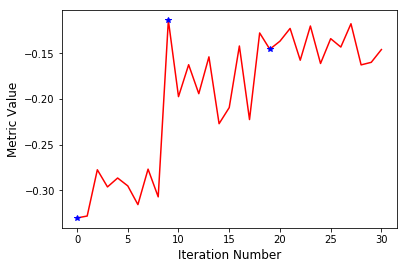

Final metric value: -0.11520586692353578
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 12.


interactive(children=(IntSlider(value=9, description='image_z', max=18), FloatSlider(value=0.0, description='a…

In [102]:
rigid_transform = create_matrix_rigid_transform()

In [103]:
def plot_fixed_moving_transformed_images(slice_index, fixed_image, moving_image, transformed_image):
    plt.figure(figsize=(15,15))
    plt.subplot(131), plt.imshow(sitk.GetArrayFromImage(fixed_image)[slice_index] , cmap="gray"), plt.title("reference sample")
    plt.subplot(132), plt.imshow(sitk.GetArrayFromImage(moving_image)[slice_index], cmap="gray"), plt.title("Image sample")
    plt.subplot(133), plt.imshow(sitk.GetArrayFromImage(transformed_image)[slice_index], cmap="gray"), plt.title("Transformed sample")

In [104]:

def checkout_registration(idx):
    img_np = join_images_table.MRI3D[idx]
    moving_image = sitk.GetImageFromArray(img_np)
    ijk = join_images_table.ijk[idx]
    transformed_image = sitk.Resample(moving_image, rigid_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
    interact(plot_fixed_moving_transformed_images, slice_index=(0,moving_image.GetSize()[2]-1),
             fixed_image = fixed(moving_image), moving_image=fixed(moving_image), transformed_image=fixed(transformed_image) );
    final_shape = sitk.GetArrayFromImage(transformed_image).shape
    
    ijk_list = ijk.split()
    ijk_np = np.array([float(ijk_list[0]),float(ijk_list[1]), float(ijk_list[2])])
    ijk_np_transformed = np.array(rigid_transform.TransformPoint(ijk_np))
    print("The point {} was transformed to {}".format(ijk_np,ijk_np_transformed))
    ijk_np_transformed = np.round(ijk_np_transformed)
    print("The final point was rounded to: {}".format(ijk_np_transformed))
    type(ijk_np_transformed)
    print("The final shape of the transformed image is: {}".format(final_shape))

In [105]:
checkout_registration(100)

interactive(children=(IntSlider(value=9, description='slice_index', max=18), Output()), _dom_classes=('widget-…

The point [50. 69. 11.] was transformed to [48.74605402 68.12063839  9.22829768]
The final point was rounded to: [49. 68.  9.]
The final shape of the transformed image is: (19, 128, 84)


In [106]:
idx = 100
idx2 = 0 
img_np = join_images_table.MRI3D[idx]
img_np2 = join_images_table.MRI3D[idx2]
moving_image = sitk.GetImageFromArray(img_np)
fixed_image  = sitk.GetImageFromArray(img_np2)
ijk = join_images_table.ijk[idx]
transformed_image = sitk.Resample(moving_image , fixed_image, rigid_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
interact(plot_fixed_moving_transformed_images, slice_index=(0,moving_image.GetSize()[2]-1),
             fixed_image = fixed(fixed_image), moving_image=fixed(moving_image), transformed_image=fixed(transformed_image) );
final_shape = sitk.GetArrayFromImage(transformed_image).shape

interactive(children=(IntSlider(value=9, description='slice_index', max=18), Output()), _dom_classes=('widget-…

In [107]:
random_numbers = np.random.randint(0,len(join_images_table),size=10)
for number in random_numbers:
    checkout_registration(number)

interactive(children=(IntSlider(value=9, description='slice_index', max=18), Output()), _dom_classes=('widget-…

The point [108. 140.   9.] was transformed to [107.36994242 138.63452862   9.05224361]
The final point was rounded to: [107. 139.   9.]
The final shape of the transformed image is: (19, 320, 320)


interactive(children=(IntSlider(value=28, description='slice_index', max=56), Output()), _dom_classes=('widget…

The point [35. 72.  9.] was transformed to [33.7743959  71.30238005  7.29801972]
The final point was rounded to: [34. 71.  7.]
The final shape of the transformed image is: (57, 128, 84)


interactive(children=(IntSlider(value=7, description='slice_index', max=14), Output()), _dom_classes=('widget-…

The point [185. 171.  11.] was transformed to [184.63838058 168.89409872  11.87126486]
The final point was rounded to: [185. 169.  12.]
The final shape of the transformed image is: (15, 320, 320)


interactive(children=(IntSlider(value=28, description='slice_index', max=56), Output()), _dom_classes=('widget…

The point [37. 75.  9.] was transformed to [35.80071755 74.28367454  7.3748552 ]
The final point was rounded to: [36. 74.  7.]
The final shape of the transformed image is: (57, 128, 84)


interactive(children=(IntSlider(value=9, description='slice_index', max=18), Output()), _dom_classes=('widget-…

The point [152. 163.  12.] was transformed to [151.56858809 161.16253732  12.65343021]
The final point was rounded to: [152. 161.  13.]
The final shape of the transformed image is: (19, 320, 320)


interactive(children=(IntSlider(value=7, description='slice_index', max=15), Output()), _dom_classes=('widget-…

The point [73. 79.  8.] was transformed to [71.83519379 77.99022939  6.49282729]
The final point was rounded to: [72. 78.  6.]
The final shape of the transformed image is: (16, 128, 128)


interactive(children=(IntSlider(value=7, description='slice_index', max=14), Output()), _dom_classes=('widget-…

The point [170. 187.   8.] was transformed to [169.78179955 185.09647581   9.27030791]
The final point was rounded to: [170. 185.   9.]
The final shape of the transformed image is: (15, 320, 320)


interactive(children=(IntSlider(value=5, description='slice_index', max=11), Output()), _dom_classes=('widget-…

The point [57. 62.  6.] was transformed to [55.68757759 61.18796574  4.0559384 ]
The final point was rounded to: [56. 61.  4.]
The final shape of the transformed image is: (12, 128, 128)


interactive(children=(IntSlider(value=6, description='slice_index', max=12), Output()), _dom_classes=('widget-…

The point [138. 134.   0.] was transformed to [ 1.37322086e+02  1.32599981e+02 -8.30353261e-02]
The final point was rounded to: [137. 133.  -0.]
The final shape of the transformed image is: (13, 256, 256)


interactive(children=(IntSlider(value=9, description='slice_index', max=18), Output()), _dom_classes=('widget-…

The point [163. 179.   5.] was transformed to [162.7137105  177.23695573   6.06561426]
The final point was rounded to: [163. 177.   6.]
The final shape of the transformed image is: (19, 320, 320)
